In [1]:
# Import libraries
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import pandas as pd
import plotly.graph_objs as go
import os
from dash.dependencies import Input, Output, State
import base64
import datetime
import io
import time
# Import the wordcloud library
from wordcloud import WordCloud
from io import BytesIO
import warnings
from collections import Counter
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from nltk.util import ngrams

In [7]:
stop = ""
lista = [stop]

len(lista)

1

In [3]:
UPLOAD_DIRECTORY = "./app_uploaded_files"
filename = "Reviews.csv"
data = pd.read_csv(os.path.join(UPLOAD_DIRECTORY, filename))

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
#df = data[['SysId','ICMREQ_ContractAdvice','Requester Team']]
df = data[['Id','Text']]
df.columns = ["id","text"]
df['text'] = df['text'].astype(str)
df['text_new'] = df.text.apply(lambda x: x.lower())

In [6]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')

token_lists = [word_tokenize(each) for each in df.text]
tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens únicos antes: ", len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in df.text_new]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Cantidad de tokens únicos ahora: ", len(set(tokens_lower)))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gvalen15\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cantidad de tokens únicos antes:  253688
Cantidad de tokens únicos ahora:  208824


In [7]:
# Seleccionar caracteres no alfanuméricos que no sean espacios
special_chars = df.text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])
# Obtener lista de lista en una sola lista
flat_list = [item for sublist in special_chars for item in sublist]
# Caracteres especiales únicos
print(set(flat_list))

{'`', '{', '¢', '=', ')', '<', '!', '&', '\x13', '|', '¨', '_', '\xad', '*', '/', '(', '±', '~', ',', '$', '\\', '\x0c', "'", '%', '\x10', '\x07', ']', '\x0f', '®', '¦', '>', '×', '^', '£', '"', '@', '»', '°', '©', '#', ';', '+', '}', '«', '?', ':', '·', '-', '§', '.', '\x8c', '¬', '\x99', '\x06', '['}


In [7]:
import re
text_backup = df.text_new.copy()
df.text_new = df.text_new.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

In [8]:
token_lists = [word_tokenize(each) for each in df.text]
tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens únicos antes: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in df.text_new]
tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens únicos después: ", len(set(tokens)))


Cantidad de tokens únicos antes:  14129
Cantidad de tokens únicos después:  10597


In [9]:
import nltk
nltk.download('stopwords')
noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gvalen15\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Find the high- and low-frequency words, which we will define as the 1% of words that occur most often in the reviews, as well as define the 1% of words that occur least often in the reviews (after adjusting for case and special characters)

In [10]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
#top_1_percentile[:10]

In [11]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
#bottom_1_percentile[:10]

Stop words and high/low frequency words have now been added to noise_words, which will be removed from the reviews prior to training machine learning models. The common words are unlikely to be that useful as we expect them to appear about as often in positive and negative reviews. The uncommon words might be more meaningful and could in theory indicate the sentiment of the review, but as they appear so seldom our model would not be able to learn any meaning from them.

In [12]:
#Not in this case
#noise_words.extend([word for word,val in top_1_percentile])

#noise_words.extend([word for word,val in bottom_1_percentile])

**Stemming algorithms** work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

On the other hand, **lemmatization** takes into consideration the morphological analysis of the words. So lemmatization takes into account the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [13]:
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer

nltk.download('wordnet')

from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

df['text_lemmatized'] = df['text_new'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gvalen15\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def remove_stops(row):
    my_list = row['text_lemmatized']
    meaningful_words = [w for w in my_list if not w in noise_words]
    return (meaningful_words)

df['text_noise_words_out'] = df.apply(remove_stops, axis=1)

In [15]:
def rejoin_words(row):
    my_list = row['text_noise_words_out']
    joined_words = ( " ".join(my_list))
    return joined_words

df['processed'] = df.apply(rejoin_words, axis=1)

In [16]:
df.head(2)

id  \
0  0001E172-72A1-4A66-A14B-B8F1C8AD47A5   
1  0059CECE-0CB9-4FE0-8781-FF4A2C3B55E9   

                                                text        columnname  \
0  Redline review (Addendum) needed for 2020 Glob...  Business Partner   
1  Transfer of Janssen projects fro EVIDERA Inc t...       BU Sourcing   

                                            text_new  \
0  redline review  addendum  needed for 2020 glob...   
1  transfer of janssen projects fro evidera inc t...   

                                     text_lemmatized  \
0  [redline, review, addendum, need, for, 2020, g...   
1  [transfer, of, janssen, project, fro, evidera,...   

                                text_noise_words_out  \
0  [redline, review, addendum, need, 2020, global...   
1  [transfer, janssen, project, fro, evidera, inc...   

                                           processed  
0  redline review addendum need 2020 global comme...  
1  transfer janssen project fro evidera inc evide...

In [17]:
def top_k_ngrams(word_tokens,n,k):
    n_gram_list = list(ngrams(word_tokens, n))
    ### Obteniendo cada n-grama como una cadena separada
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    df = pd.DataFrame(most_common_k, columns =['ngram', 'value'])
    return df
    #print(df.head(5))

In [18]:
 ### Obteniendo una sola cadena
text1 = df[df['columnname']=='Business Partner']["processed"]
text2 = df[df['columnname']=='BU Sourcing']["processed"]

all_text1 = ' '.join(text1)
all_text2 = ' '.join(text2)
## Dividirlos en tokens
word_tokens1 = nltk.word_tokenize(all_text1)
word_tokens2 = nltk.word_tokenize(all_text2)
## Llamando a la función para top k
result1 = top_k_ngrams(word_tokens1, 2, 10)
result1['value'] = "Business Partner"
result2 = top_k_ngrams(word_tokens2, 2, 10)
result2['value'] = "BU Sourcing"

result = result1.append(result2,ignore_index=True)
print(result.head(100))

                       ngram             value
0                   ad board  Business Partner
1             advisory board  Business Partner
2                totality id  Business Partner
3          consult agreement  Business Partner
4          contract template  Business Partner
5               rush request  Business Partner
6            steer committee  Business Partner
7   individual institutional  Business Partner
8            contract advice  Business Partner
9               legal review  Business Partner
10                       j j       BU Sourcing
11                would like       BU Sourcing
12                work order       BU Sourcing
13           contract advice       BU Sourcing
14          master agreement       BU Sourcing
15          business partner       BU Sourcing
16         service agreement       BU Sourcing
17             please advise       BU Sourcing
18             need contract       BU Sourcing
19              change order       BU Sourcing


In [19]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(df.text_noise_words_out)
# Create Corpus
texts = df.text_noise_words_out
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [40]:
len(corpus)

3264

In [20]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [21]:
from pprint import pprint
# number of topics


# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


    
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.399396505053677
Coherence Score:  0.4339419867657403


In [22]:
print(lda_model.print_topics())

[(0, '0.028*"agreement" + 0.028*"template" + 0.028*"board" + 0.025*"totality" + 0.024*"contract" + 0.022*"request" + 0.020*"please" + 0.020*"need" + 0.018*"individual" + 0.016*"review"'), (1, '0.025*"wo" + 0.015*"2019" + 0.010*"system" + 0.008*"advance" + 0.008*"30" + 0.007*"cancer" + 0.007*"equipment" + 0.007*"amount" + 0.007*"correct" + 0.007*"date"'), (2, '0.029*"contract" + 0.020*"msa" + 0.018*"need" + 0.018*"j" + 0.016*"supplier" + 0.016*"would" + 0.013*"agreement" + 0.013*"work" + 0.012*"service" + 0.011*"attach"'), (3, '0.020*"committee" + 0.020*"steer" + 0.018*"fee" + 0.012*"de" + 0.009*"n" + 0.008*"affiliate" + 0.008*"el" + 0.008*"que" + 0.007*"study" + 0.007*"program"'), (4, '0.029*"global" + 0.013*"leverage" + 0.012*"france" + 0.012*"group" + 0.009*"patient" + 0.009*"canada" + 0.009*"uk" + 0.009*"research" + 0.008*"report" + 0.008*"name"')]


In [23]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    original_id = pd.Series(df['id'])
    sent_topics_df = pd.concat([sent_topics_df, contents,original_id], axis=1)
    
    return(sent_topics_df)

In [24]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','Id']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.5462   
1            1             2.0              0.6130   
2            2             2.0              0.8746   
3            3             2.0              0.8059   
4            4             0.0              0.8327   
5            5             0.0              0.6470   
6            6             0.0              0.8887   
7            7             0.0              0.6607   
8            8             0.0              0.6497   
9            9             0.0              0.8503   

                                            Keywords  \
0  agreement, template, board, totality, contract...   
1  contract, msa, need, j, supplier, would, agree...   
2  contract, msa, need, j, supplier, would, agree...   
3  contract, msa, need, j, supplier, would, agree...   
4  agreement, template, board, totality, contract...   
5  agreement, template, board, totality, contract...   
6  agreement, template, board, totality, contract...   
7  agreement, template, board, totality, contract...   
8  agreement, template, board, totality, contract...   
9  agreement, template, board, totality, contract...   

                                                Text  \
0  [redline, review, addendum, need, 2020, global...   
1  [transfer, janssen, project, fro, evidera, inc...   
2  [jnj, medical, evergreen, agreement, insightso...   
3  [bs, ask, support, get, contract, sign, provid...   
4  [contract, advise, legal, review, redline, agr...   
5  [hi, liz, please, see, attach, redline, review...   
6  [china, individual, template, ad, board, 2020,...   
7  [contract, template, steer, committee, consult...   
8  [aaron, millers, totality, 363570, addendum, r...   
9  [super, rush, request, process, addendum, redl...   

                                     Id  
0  0001E172-72A1-4A66-A14B-B8F1C8AD47A5  
1  0059CECE-0CB9-4FE0-8781-FF4A2C3B55E9  
2  005D4447-FDC6-430E-8BB6-AF8DF876430C  
3  00707C4B-9426-4966-99CD-95C0133314E9  
4  0092257C-5E40-4C2D-A272-065090758417  
5  00A73214-6C2B-4445-8276-832BAD40AA81  
6  00E87983-17D5-4C73-9B22-8AD87CE15506  
7  00F7FC4F-98D0-4B71-9BB1-1AB71E577A94  
8  00FC0CE9-88A8-472C-BA94-0B654601E11D  
9  00FE7FE0-7356-4994-94D1-1DC818778522

In [38]:
df_dominant_topic[df_dominant_topic.Id == 'FFA78E6C-6614-452F-B494-0262F263C9E7']

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
3260         3260             0.0              0.7943   

                                                                                       Keywords  \
3260  agreement, template, board, totality, contract, request, please, need, individual, review   

                                                                                                     Text  \
3260  [rush, request, contract, advice, legal, review, follow, attach, please, find, msk, request, rev...   

                                        Id  
3260  FFA78E6C-6614-452F-B494-0262F263C9E7

In [26]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text","Id"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9553   
1        1.0              0.7345   
2        2.0              0.9679   
3        3.0              0.9402   
4        4.0              0.8890   

                                                                                    Keywords  \
0  agreement, template, board, totality, contract, request, please, need, individual, review   
1                    wo, 2019, system, advance, 30, cancer, equipment, amount, correct, date   
2                  contract, msa, need, j, supplier, would, agreement, work, service, attach   
3                           committee, steer, fee, de, n, affiliate, el, que, study, program   
4               global, leverage, france, group, patient, canada, uk, research, report, name   

                                                                                   Representative Text  \
0  [rush, request, kol, agreement, templates, copy, individual, institutional, templates, need, vir...   
1  [frontline, indication, discussion, maia, cassiopeia, result, 03, 26, 2019, 6, 10, 2019, japan, ...   
2  [business, partner, would, like, terminate, hcl, service, attachment, po, pr1774465, cause, busi...   
3  [queremos, generar, una, po, para, el, pago, de, los, servicios, que, nos, prest, el, proveedor,...   
4  [belgium, individual, template, patient, advocate, global, patient, advisory, car, council, gpac...   

                                     Id  
0  523E031D-D577-4C3E-A0BA-E92A10E1ACD3  
1  0E65B6C4-B44E-4D84-B877-8E915249FE34  
2  0D155D4A-E2A0-4F8A-93A2-FC4BE3A2D69E  
3  D59D9C79-7DCB-4E4C-8CAE-E5E9D990014B  
4  2B83BE6B-C954-49BD-BE10-E35A2A339D35

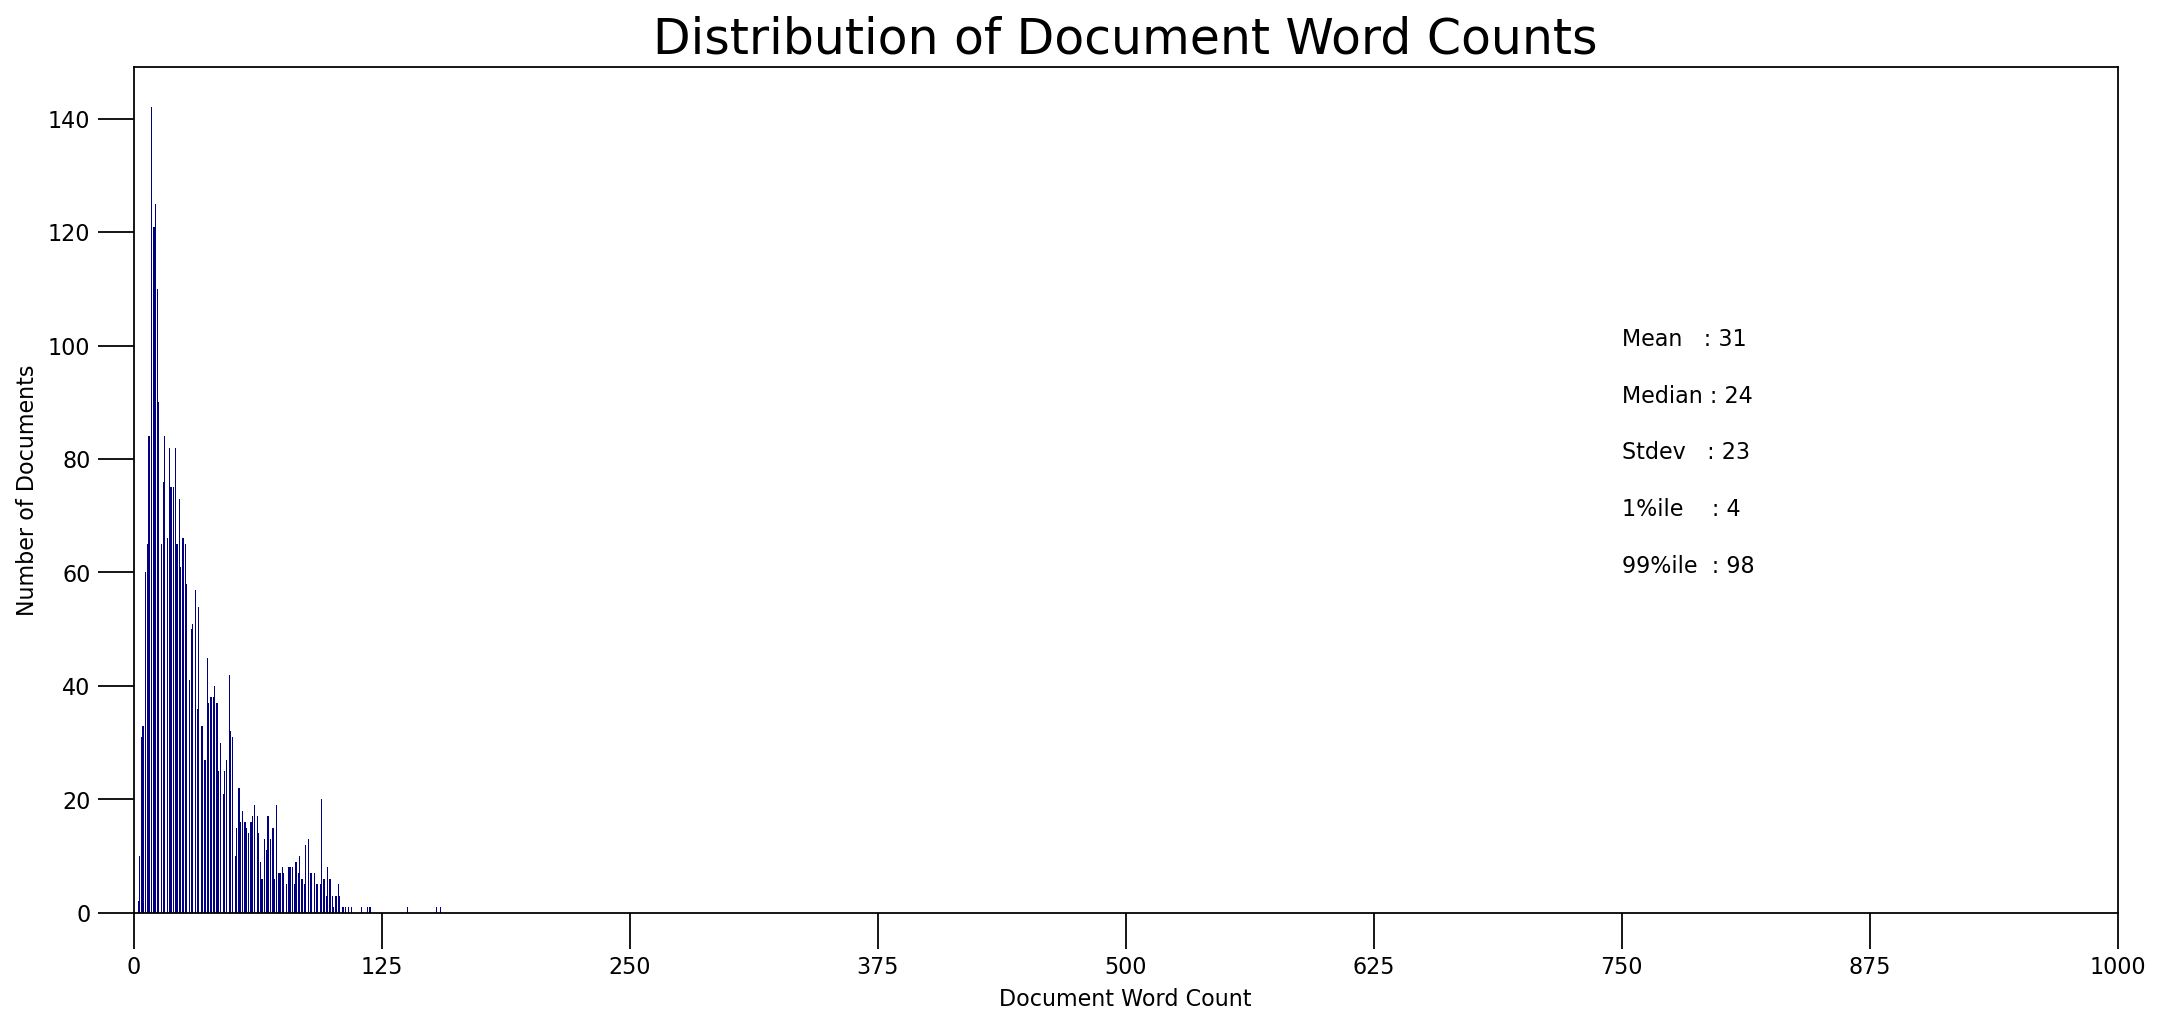

In [27]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 250, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [28]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

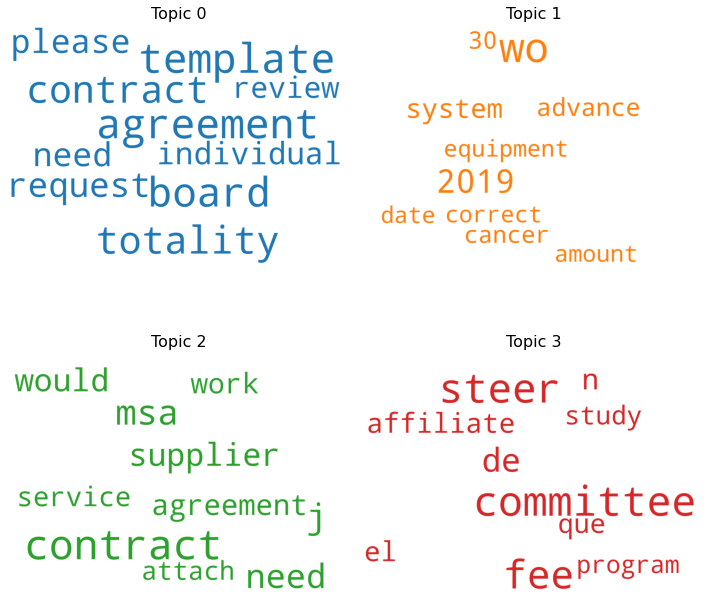

In [29]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=noise_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [30]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [5]:
titles = []
type(titles)

list

In [74]:
 topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])   

specs=[[{"secondary_y": True}, {"secondary_y": True}],
               [{"secondary_y": True}, {"secondary_y": True}]]

In [88]:

for i in range(3):
    temp = [{"secondary_y":True},{"secondary_y":True}]
    finalVar.append(temp)
finalVar
3%2


1

In [91]:
number_of_topics = df.topic_id.nunique()
number_of_rows = (number_of_topics // 2) + 1
finalspecs = []
for i in range(number_of_rows):
    temp = [{"secondary_y":True},{"secondary_y":True}]
    finalspecs.append(temp)
fig = make_subplots(rows=number_of_rows, cols=2, specs=finalspecs)

for i in range(0,number_of_topics):
    if i==0:
        rows = 1
        cols = 1
    elif i % 2 == 0:
        rows+=1
        cols=1
    else:
        cols+=1
    topic_df = df.loc[df.topic_id==i, :]
    fig.add_trace( go.Bar(x=topic_df.word, y=topic_df.word_count,width=0.5,name="Word Count",marker_color=mycolors[i],opacity=0.6),secondary_y=False,row=rows, col=cols)
    fig.add_trace( go.Bar(x=topic_df.word, y=topic_df.importance,width=0.2,name="Weight",marker_color=mycolors[i]),secondary_y=True,row=rows, col=cols)

In [92]:
fig

In [64]:
import plotly.express as px
fig = make_subplots(rows=2, cols=2,
         specs=[[{"secondary_y": True}, {"secondary_y": True}],
               [{"secondary_y": True}, {"secondary_y": True}]])
i = 0
final = df.loc[df.topic_id==i, :]
fig.add_trace( go.Bar(x=final.word, y=final.word_count,width=0.5,name="Word Count",marker_color=mycolors[i],opacity=0.6),secondary_y=False,row=1, col=1)
fig.add_trace( go.Bar(x=final.word, y=final.importance,width=0.2,name="Weight",marker_color=mycolors[i]),secondary_y=True,row=1, col=1)

In [31]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [32]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

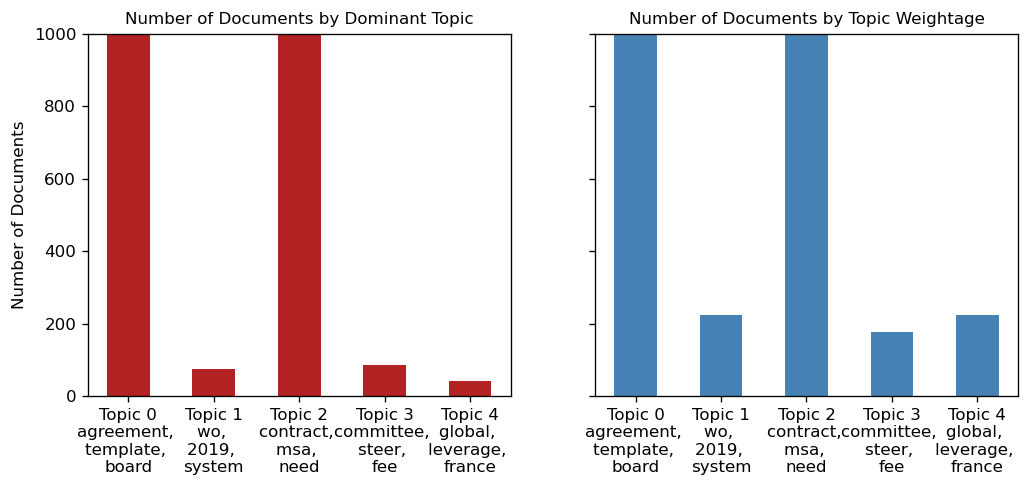

In [33]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [41]:
lda_model[corpus]

In [49]:
from plotly.subplots import make_subplots

In [50]:
fig = makesubplots(rows=2, cols=3)

NameError: name 'makesubplots' is not defined

In [45]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np
import matplotlib.colors as mcolors
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

print(len(topic_num))
print(len(tsne_lda))

df1 = pd.DataFrame(tsne_lda, columns = ['X','Y'])
df2 = pd.DataFrame(topic_num, columns = ['Topic_Number'])
result = pd.concat([df1, df2,df_dominant_topic], axis=1)
result

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3264 samples in 0.003s...
[t-SNE] Computed neighbors for 3264 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3264
[t-SNE] Computed conditional probabilities for sample 2000 / 3264
[t-SNE] Computed conditional probabilities for sample 3000 / 3264
[t-SNE] Computed conditional probabilities for sample 3264 / 3264
[t-SNE] Mean sigma: 0.013718
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.729736
[t-SNE] KL divergence after 1000 iterations: 0.716653
3264
3264


X          Y  Topic_Number  Document_No  Dominant_Topic  \
0    -11.058980  17.887320             0            0             0.0   
1     22.619532  19.006729             2            1             2.0   
2     44.777061  -1.897306             2            2             2.0   
3      2.254543  50.031807             1            3             2.0   
4    -35.536705  -9.886718             0            4             0.0   
...         ...        ...           ...          ...             ...   
3259 -12.316273 -42.440449             0         3259             0.0   
3260 -27.880590   1.597585             0         3260             0.0   
3261  45.107243  -7.685643             2         3261             2.0   
3262  35.275497  -3.372206             2         3262             2.0   
3263   8.696227  55.192749             1         3263             2.0   

      Topic_Perc_Contrib  \
0                 0.5462   
1                 0.6130   
2                 0.8746   
3                 0.8059   
4                 0.8327   
...                  ...   
3259              0.7138   
3260              0.7943   
3261              0.8512   
3262              0.7538   
3263              0.8949   

                                                                                       Keywords  \
0     agreement, template, board, totality, contract, request, please, need, individual, review   
1                     contract, msa, need, j, supplier, would, agreement, work, service, attach   
2                     contract, msa, need, j, supplier, would, agreement, work, service, attach   
3                     contract, msa, need, j, supplier, would, agreement, work, service, attach   
4     agreement, template, board, totality, contract, request, please, need, individual, review   
...                                                                                         ...   
3259  agreement, template, board, totality, contract, request, please, need, individual, review   
3260  agreement, template, board, totality, contract, request, please, need, individual, review   
3261                  contract, msa, need, j, supplier, would, agreement, work, service, attach   
3262                  contract, msa, need, j, supplier, would, agreement, work, service, attach   
3263                  contract, msa, need, j, supplier, would, agreement, work, service, attach   

                                                                                                     Text  \
0     [redline, review, addendum, need, 2020, global, commercial, lung, cancer, virtual, advisory, boa...   
1            [transfer, janssen, project, fro, evidera, inc, evidera, ltd, include, change, bank, detail]   
2     [jnj, medical, evergreen, agreement, insightsoftware, com, limit, earlier, know, decision, softw...   
3     [bs, ask, support, get, contract, sign, provide, document, state, extension, service, agreement,...   
4     [contract, advise, legal, review, redline, agreement, dr, garcia, manero, please, incorporate, m...   
...                                                                                                   ...   
3259                                    [us, one, time, hcp, consult, template, 2019, fall, idea, summit]   
3260  [rush, request, contract, advice, legal, review, follow, attach, please, find, msk, request, rev...   
3261  [j, j, extremely, old, master, agreement, ul, eduneering, process, negotiate, new, master, saas,...   
3262  [hello, team, would, like, hear, advice, best, approach, case, 07575486, new, supplier, euromone...   
3263  [regard, totality, 330687, advise, sign, document, include, agreements, display, e, janssen, pay...   

                                        Id  
0     0001E172-72A1-4A66-A14B-B8F1C8AD47A5  
1     0059CECE-0CB9-4FE0-8781-FF4A2C3B55E9  
2     005D4447-FDC6-430E-8BB6-AF8DF876430C  
3     00707C4B-9426-4966-99CD-95C0133314E9  
4     0092257C-5E40-4C2D-A272-065090758417  
...                             

In [46]:
# Top 3 Keywords for each Topic
topic_top6words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 6]

df_top6words_stacked = pd.DataFrame(topic_top6words, columns=['topic_id', 'words'])
df_top6words = df_top6words_stacked.groupby('topic_id').agg(', \n'.join)
df_top6words.reset_index(level=0,inplace=True)
df_top6words

topic_id                                                              words
0         0  agreement, \ntemplate, \nboard, \ntotality, \ncontract, \nrequest
1         1                    wo, \n2019, \nsystem, \nadvance, \n30, \ncancer
2         2                  contract, \nmsa, \nneed, \nj, \nsupplier, \nwould
3         3                  committee, \nsteer, \nfee, \nde, \nn, \naffiliate
4         4         global, \nleverage, \nfrance, \ngroup, \npatient, \ncanada

In [121]:
traces = []
for topic_id in df_top6words["topic_id"]:
        tsne_df_f = result[result.Topic_Number == topic_id]
        cluster_name = ", ".join(
            df_top6words[df_top6words["topic_id"] == topic_id]["words"].to_list()
        )
        trace = go.Scatter(
            name=cluster_name,
            x=tsne_df_f["X"],
            y=tsne_df_f["Y"],
            mode="markers",
            marker=dict(
                size=6,
                color=mycolors[tsne_df_f["Topic_Number"]],  # set color equal to a variable
                colorscale="Viridis",
                showscale=False,
            ),
        )
        traces.append(trace)

layout = go.Layout({"title": "Topic analysis using LDA"})

In [ ]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(2), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

1120978


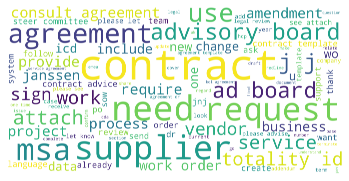

In [69]:
word_cloud_text = ''.join(df.processed)

print(len(word_cloud_text))
wordcloud = WordCloud(
max_font_size=100,
max_words=100,
background_color="white",
scale=10,
width=800,
height=400
).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Check

In [104]:
import plotly.express as px

df = px.data.iris()

In [106]:
features = df.loc[:, :'petal_width']

In [107]:
features

sepal_length  sepal_width  petal_length  petal_width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns]